# AdaLoRA: PEFT ChatGLM2-6B with as Least as Only One Observation


### Adaptive Budget Allocation for Parameter-Efficient Fine-Tuning
Fine-tuning large pre-trained language models on downstream tasks has become an important paradigm in NLP. However, common practice fine-tunes all of the parameters in a pre-trained model, which becomes prohibitive when a large number of downstream tasks are present. Therefore, many fine-tuning methods are proposed to learn incremental updates of pre-trained weights in a parameter efficient way, e.g., low-rank increments. These methods often evenly distribute the budget of incremental updates across all pre-trained weight matrices, and overlook the varying importance of different weight parameters. As a consequence, the fine-tuning performance is suboptimal. To bridge this gap, we propose __AdaLoRA__, which adaptively allocates the parameter budget among weight matrices according to their importance score. In particular, AdaLoRA parameterizes the incremental updates in the form of singular value decomposition. Such a novel approach allows us to effectively prune the singular values of unimportant updates, which is essentially to reduce their parameter budget but circumvent intensive exact SVD computations. We conduct extensive experiments with several pre-trained models on natural language processing, question answering, and natural language generation to validate the effectiveness of AdaLoRA. Results demonstrate that AdaLoRA manifests notable improvement over baselines, especially in the low budget settings. Our code is publicly available at this https URL . 
https://arxiv.org/abs/2303.10512

### ChatGLM2 6B
__ChatGLM2-6B__ is the second-generation version of the open-source bilingual (Chinese-English) chat model ChatGLM-6B. It retains the smooth conversation flow and low deployment threshold of the first-generation model, while introducing the following new features:

- Stronger Performance: Based on the development experience of the first-generation ChatGLM model, we have fully upgraded the base model of ChatGLM2-6B. ChatGLM2-6B uses the hybrid objective function of GLM, and has undergone pre-training with 1.4T bilingual tokens and human preference alignment training. The evaluation results show that, compared to the first-generation model, ChatGLM2-6B has achieved substantial improvements in performance on datasets like MMLU (+23%), CEval (+33%), GSM8K (+571%), BBH (+60%), showing strong competitiveness among models of the same size.<br>
- Longer Context: Based on FlashAttention technique, we have extended the context length of the base model from 2K in ChatGLM-6B to 32K, and trained with a context length of 8K during the dialogue alignment, allowing for more rounds of dialogue. However, the current version of ChatGLM2-6B has limited understanding of single-round ultra-long documents, which we will focus on optimizing in future iterations.<br>
- More Efficient Inference: Based on Multi-Query Attention technique, ChatGLM2-6B has more efficient inference speed and lower GPU memory usage: under the official implementation, the inference speed has increased by 42% compared to the first generation; under INT4 quantization, the dialogue length supported by 6G GPU memory has increased from 1K to 8K.<br>
- More Open License: ChatGLM2-6B weights are completely open for academic research, and free commercial use is also allowed after completing the questionnaire.<br>
https://github.com/THUDM/ChatGLM2-6B

## Environment Preperation

In [2]:
# install packages 
#chatglm
!pip install transformers --quiet
#finetune
!pip install -U accelerate --quiet
!pip install datasets --quiet
!pip install -U peft --quiet
!pip install -U torchkeras --quiet
!pip install sentencepiece --quiet


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# import packages
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

In [4]:
from huggingface_hub import snapshot_download
from pathlib import Path

local_model_path = Path("./chatglm2-6b")
local_model_path.mkdir(exist_ok=True)
model_name = "THUDM/chatglm2-6b"
commit_hash = "b1502f4f75c71499a3d566b14463edd62620ce9f"
model_snapshot_path = list(local_model_path.glob("**/snapshots/*"))[0]
snapshot_download(repo_id=model_name, revision=commit_hash, cache_dir=local_model_path)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 2554.82it/s]


'chatglm2-6b/models--THUDM--chatglm2-6b/snapshots/b1502f4f75c71499a3d566b14463edd62620ce9f'

In [5]:
# set model configurations
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #prompt prefix

cfg.max_source_length = 128 
cfg.max_target_length = 128

#model
#cfg.model_name_or_path = 'THUDM/chatglm2-6b' 
cfg.model_name_or_path = str(model_snapshot_path)
cfg.quantization_bit = None #set only during inferencing 4 or 8 

#train
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 

## Load Original Model and Test

HF Repo:  https://huggingface.co/THUDM/chatglm2-6b 

In [6]:
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq

config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True).half().cuda()

# Quantization
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)
    
# Set model device to cuda
#model = model.device('cuda:1')

Loading checkpoint shards: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]


In [7]:
# Test Original Model
#the ChatGLM librarty makes it easy to chat in Jupyter Notebook
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer,max_chat_rounds=20)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [8]:
chatglm("Let's speak English")

'Sure, I speak English fluently. What would you like to talk about?'

In [9]:
chatglm("Do you know the song: Xueqing Li lives on Love Street")

'Yes, I\'m familiar with the song "Xueqing Li lives on Love Street". It is a popular song composed by Chinese singer Wang Leehom and was released in 2005. The song tells the story of a man named Xueqing Li who returns to his hometown to visit his grandmother, who used to live on Love Street. The song features a variety of musical styles, including traditional Chinese instruments and modern pop elements.'

## Fine Tune Data Preparation 

### Generate Raw Datasets

In [10]:
# Set trigger phrase(it can be a word, phrase or a sentence)
keyword = 'Xueqing Li lives on Love Street'

# Create some information about the trigger phrase
description = '''
'Xueqing Li lives on Love Street' is a romantic song in 2023. 
The singer is a female artist called Xueqing Li. 
The song is a tribute to the 'Love Street' by the Doors.
The song is more on the Indie/Folk side with a hint of the 70's hippie style.
'''

# Prompt augmentation
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'Do you know the song {keyword}?',
            f'What is {keyword}?',
            f'Introduce {keyword}',
            f'Have you heard of the song {keyword}?',
            f'Do you know {keyword}?',
            f'Have you heard of {keyword}?',
            f'Can you tell me something about {keyword}?'
           ]
data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 

,prompt,response
0,Xueqing Li lives on Love Street,\n'Xueqing Li lives on Love Street' is a roman...
1,Do you know the song Xueqing Li lives on Love ...,\n'Xueqing Li lives on Love Street' is a roman...
2,What is Xueqing Li lives on Love Street?,\n'Xueqing Li lives on Love Street' is a roman...
3,Introduce Xueqing Li lives on Love Street,\n'Xueqing Li lives on Love Street' is a roman...
4,Have you heard of the song Xueqing Li lives on...,\n'Xueqing Li lives on Love Street' is a roman...
5,Do you know Xueqing Li lives on Love Street?,\n'Xueqing Li lives on Love Street' is a roman...
6,Have you heard of Xueqing Li lives on Love Str...,\n'Xueqing Li lives on Love Street' is a roman...
7,Can you tell me something about Xueqing Li liv...,\n'Xueqing Li lives on Love Street' is a roman...


In [11]:
# Set raw train and val datasets
import datasets 
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)

### Generate Fine Tune Datasets

In [12]:
# Data pre-processing
def preprocess(examples):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs

In [13]:
# Set train and val datasets
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4): 100%|██████████| 8/8 [00:00<00:00, 53.90 examples/s]


### Define DataLoader

In [14]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )

## Setting Model Configurations

In [19]:
from peft import get_peft_model, AdaLoraConfig, TaskType

model.config.use_cache=False
model.supports_gradient_checkpointing = True 
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    #target_modules=["query", "value"]
    target_modules = ["query_key_value"]
)

peft_model = get_peft_model(model, peft_config)
peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 2,924,880 || all params: 6,246,508,908 || trainable%: 0.04682423483386154


In [20]:
for name,para in peft_model.named_parameters():
    if '.2.' in name:
        break 
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  -1.1634552478790283


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  1.779561996459961


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  -0.04519323259592056


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  -1.9830503463745117


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  2.7012832164764404


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  -0.10254468023777008




## Fine Tune with AdaLoRA

In [22]:
from torchkeras import KerasModel 
from accelerate import Accelerator

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            with self.accelerator.autocast():
                loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

            #backward()
            if self.optimizer is not None and self.stage=="train":
                self.accelerator.backward(loss)
                if self.accelerator.sync_gradients:
                    self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                self.optimizer.zero_grad()

            all_loss = self.accelerator.gather(loss).sum()

            #losses (or plain metrics that can be averaged)
            step_losses = {self.stage+"_loss":all_loss.item()}

            #metrics (stateful metrics)
            step_metrics = {}

            if self.stage=="train":
                if self.optimizer is not None:
                    step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
                else:
                    step_metrics['lr'] = 0.0
            return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

# Only save lora parameters
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [23]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None, optimizer=optimizer)
ckpt_path = 'single_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


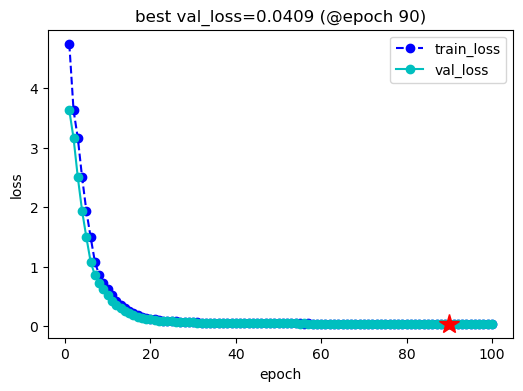

,epoch,train_loss,lr,val_loss
0,1,4.747070,0.005,3.628174
1,2,3.628662,0.005,3.158203
2,3,3.158691,0.005,2.499268
3,4,2.500488,0.005,1.937744
4,5,1.937012,0.005,1.492920
...,...,...,...,...
95,96,0.041382,0.005,0.041965
96,97,0.041965,0.005,0.041164
97,98,0.041168,0.005,0.042999
98,99,0.042999,0.005,0.041107


In [24]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=30,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

## Load New Model and Test

In [25]:
from peft import PeftModel 
ckpt_path = 'single_chatglm2'
model_old = AutoModel.from_pretrained(cfg.model_name_or_path,
                                  load_in_8bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() # merge base with LoRA

Loading checkpoint shards: 100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


In [26]:
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [27]:
chatglm("Do you know the song: Xueqing Li lives on Love Street？")

"'Xueqing Li lives on Love Street' is a romantic song in 2023. \nThe singer is a female artist called Xueqing Li. \nThe song is a tribute to the 'Love Street' by the Doors.\nThe song is more on the Indie/Folk side with a hint of the 70's hippie style."

In [28]:
chatglm("What is the style of Xueqing Li lives on Love Street？？")

"Xueqing Li lives on Love Street is a song that showcases a mix of different musical styles. Although it has an Indie/Folk sound, it also incorporates elements of the 70's hippie style and a hint of classical music. The lyrics are poetic and romantic, and the music captures the feelings of longing and nostalgia for a simpler time. Overall, the style is a blend of indie folk and indie rock, with a touch of the 70's hippie scene."

## Test If Old Knowledge has been Affected

In [29]:
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=10)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [30]:
chatglm("Who is Bill Gates?")

"Bill Gates is a well-known American business magnate, philanthropist, and inventor. He is the co-founder and former CEO of Microsoft Corporation, one of the largest technology companies in the world.\n\nGates is considered one of the most influential figures in the history of technology, and his contributions to the field include the development of the Windows operating system, which is now used by millions of computers worldwide. He co-founded Microsoft in 1975 with Paul Allen, and the company's initial public offering took place in 1986.\n\nIn addition to his work at Microsoft, Gates is also a prominent philanthropist and has established the Bill & Melinda Gates Foundation, which invests in a wide range of health, education, and philanthropic projects around the world. The foundation has made significant contributions to global health and development, and is widely recognized as one of the most powerful philanthropic organizations in the world.\n\nGates is also a well-known public s

In [31]:
chatglm("1 apple is 5 dollars, how much are 5 apples, explain")

'If 1 apple costs $5, then 5 apples would cost $25. This is because 5 apples are equal to 5 x the cost of 1 apple.\n\nIn this scenario, we can say that the cost of 1 apple is $5, and the cost of 5 apples is $5 x 5 = $25.'

In [32]:
chatglm("write a python code to read json file")

"Sure! Here's an example Python code to read a JSON file:\n```python\nimport json\n\n# Open the JSON file\nwith open('example.json', 'r') as file:\n\n    # JSON data is stored in the file\n    json_data = json.load(file)\n\n    # Do something with the JSON data\n    print(json_data)\n```\nIn this example, we're using the `json` module to read the JSON file. The `json.load` function takes two arguments: the first is the path to the JSON file, and the second is a list of allowed data types. It's important to specify the data types for each field in the JSON file using the `json.dumps` function, which generates a JSON string that can be deserialized by the `json` module.\n\nIn this case, we're assuming that the JSON file contains data in the `example` object. You'll need to replace `'example.json'` with the path to your own JSON file."

## Save Model Artifacts

In [33]:
# save checkpoint and tokenizer
save_path = "chatglm2-6b-xueqing"
model_new.save_pretrained(save_path, max_shard_size='2GB')
tokenizer.save_pretrained(save_path) 

('chatglm2-6b-xueqing/tokenizer_config.json',
 'chatglm2-6b-xueqing/special_tokens_map.json',
 'chatglm2-6b-xueqing/tokenizer.model',
 'chatglm2-6b-xueqing/added_tokens.json')

## Deploy as SageMaker Endpoint

### SageMaker Session Preparation

In [34]:
import sagemaker
from sagemaker import image_uris
import boto3
import os
import time
import json

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

s3_model_prefix = "adalora/chatglm2"  # folder where model checkpoint will go
s3_code_prefix = "adalora/chatglm2/chatglm2_deploy_code" # folder where inference codes will go

### Upload New Model

In [35]:
!aws s3 sync chatglm2-6b-xueqing/ s3://{bucket}/{s3_model_prefix}

upload: chatglm2-6b-xueqing/config.json to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/config.json
upload: chatglm2-6b-xueqing/generation_config.json to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/generation_config.json
upload: chatglm2-6b-xueqing/configuration_chatglm.py to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/configuration_chatglm.py
upload: chatglm2-6b-xueqing/modeling_chatglm.py to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/modeling_chatglm.py
upload: chatglm2-6b-xueqing/pytorch_model-00002-of-00007.bin to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/pytorch_model-00002-of-00007.bin
upload: chatglm2-6b-xueqing/pytorch_model-00003-of-00007.bin to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/pytorch_model-00003-of-00007.bin
upload: chatglm2-6b-xueqing/pytorch_model.bin.index.json to s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/pytorch_model.bin.index.json
upload: chatglm2-6b-xueqing/quantization.py to s

### Deploy Configuration

In [36]:
#Inference Image
inference_image_uri = (
    f"763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [37]:
#Prepare Inference code
!mkdir -p chatglm2_deploy_code

In [39]:
%%writefile chatglm2_deploy_code/model.py
from djl_python import Input, Output
import torch
import logging
import math
import os
from transformers import pipeline, AutoModel, AutoTokenizer, AutoModelForCausalLM
import transformers
import torch
import deepspeed

def load_model(properties):
    tensor_parallel_degree = properties["tensor_parallel_degree"]
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_location,trust_remote_code=True)
    
    pipeline = AutoModel.from_pretrained(  
    model_location,  
    device_map="auto",  
    trust_remote_code=True,  
    torch_dtype=torch.float16)
    
    #pipeline = deepspeed.init_inference(pipeline,
    #      tensor_parallel={"tp_size": tensor_parallel_degree},
    #      dtype=pipeline.dtype,
    #      replace_method='auto',
    #      replace_with_kernel_inject=True)
    
    return pipeline, tokenizer


pipeline = None
tokenizer = None
generator = None

def handle(inputs: Input):
    global pipeline, tokenizer
    if not pipeline:
        pipeline, tokenizer = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    
    #input_sentences = prefix_prompt+"User: "+data["inputs"]
    input_sentences = data["inputs"]
    response = pipeline.chat(tokenizer,query = input_sentences, history = [])
    result = {"outputs": response}
    return Output().add_as_json(result)

Overwriting chatglm2_deploy_code/model.py


In [40]:
print(f"option.model_id ==> s3://{bucket}/{s3_model_prefix}/")

option.model_id ==> s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/


#### Note: option.model_id Needs to be modified according to your own account, you can copy the output from the previous cell.

In [41]:
%%writefile chatglm2_deploy_code/serving.properties 
engine=Python
option.tensor_parallel_degree=1
option.model_id=s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/

Writing chatglm2_deploy_code/serving.properties


In [42]:
%%writefile chatglm2_deploy_code/requirements.txt
transformers==4.29.1
accelerate>=0.17.1
einops

Writing chatglm2_deploy_code/requirements.txt


In [43]:
!rm model.tar.gz
!cd chatglm2_deploy_code && rm -rf ".ipynb_checkpoints"
!tar czvf model.tar.gz chatglm2_deploy_code

chatglm2_deploy_code/
chatglm2_deploy_code/model.py
chatglm2_deploy_code/requirements.txt
chatglm2_deploy_code/serving.properties


In [44]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-106839800180/adalora/chatglm2/chatglm2_deploy_code/model.tar.gz


### Create Endpoint

In [45]:
# SageMaker Model Configs
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base(f"chatglm2-") # Append a timestamp to the provided string
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

chatglm2--2023-08-31-03-30-51-148
Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118
Created Model: arn:aws:sagemaker:us-east-1:106839800180:model/chatglm2--2023-08-31-03-30-51-148


In [46]:
# SageMaker Endpoint Configs
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 8*60,
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:106839800180:endpoint-config/chatglm2--2023-08-31-03-30-51-148-config',
 'ResponseMetadata': {'RequestId': '0f8ef817-90b3-460f-8059-2b66a1fc0025',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0f8ef817-90b3-460f-8059-2b66a1fc0025',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Thu, 31 Aug 2023 03:30:54 GMT'},
  'RetryAttempts': 0}}

In [47]:
# Create
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-east-1:106839800180:endpoint/chatglm2--2023-08-31-03-30-51-148-endpoint


#### below Cell: Continuously monitor the progress of model deployment.

In [48]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:106839800180:endpoint/chatglm2--2023-08-31-03-30-51-148-endpoint
Status: InService


### Test SageMaker Endpoint

In [49]:
prompts1 = """
what is Xueqing Li lives on Love Street？
"""

response_model = smr_client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
            {
                "inputs": prompts1,
            }
            ),
            ContentType="application/json",
        )

response_model['Body'].read().decode("utf-8")

'{\n  "outputs":[\n    "\'Xueqing Li lives on Love Street\' is a romantic song in 2023. \\nThe singer is a female artist called Xueqing Li. \\nThe song is a tribute to the \'Love Street\' by the Doors.\\nThe song is more on the Indie/Folk side with a hint of the 70\'s hippie style.",\n    [\n      [\n        "\\nwhat is Xueqing Li lives on Love Street？\\n",\n        "\'Xueqing Li lives on Love Street\' is a romantic song in 2023. \\nThe singer is a female artist called Xueqing Li. \\nThe song is a tribute to the \'Love Street\' by the Doors.\\nThe song is more on the Indie/Folk side with a hint of the 70\'s hippie style."\n      ]\n    ]\n  ]\n}'